In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
import MATS

import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("poster")


HAPI version: 1.1.1.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


c:\users\ema3\mats\MATS\spectrum.py:149: RuntimeWarning: divide by zero encountered in reciprocal
  self.tau = (self.alpha*CONSTANTS['c'] / 1e12)**-1
C:\Users\ema3\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ema3\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


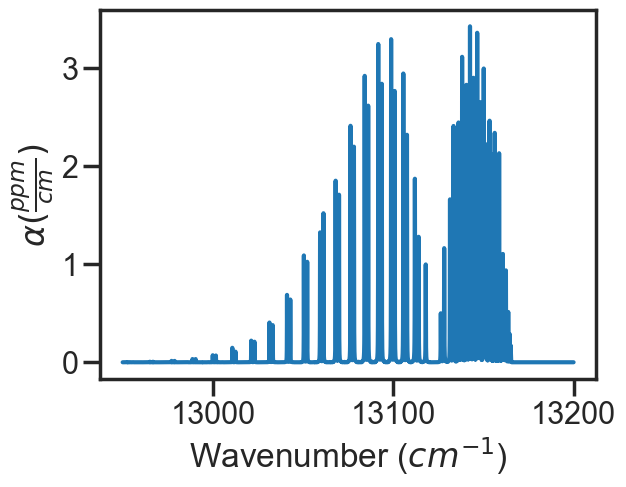

In [2]:
from MATS.linelistdata import linelistdata
PARAM_LINELIST = linelistdata['O2_ABand_Drouin_2017_linelist']

wave_range = 1.5 #range outside of experimental x-range to simulate
IntensityThreshold = 1e-30 #intensities must be above this value to be simulated
Fit_Intensity = 1e-24 #intensities must be above this value for the line to be fit
order_baseline_fit = 1
sample_molefraction = {7 :0.0025142}
wave_min = 12950 #cm-1
wave_max = 13200 #cm-1
wave_space = 0.005 #cm-1
wavenumbers = np.arange(wave_min, 13158, 0.02)



spec_1 =  MATS.simulate_spectrum(PARAM_LINELIST, wave_min=wave_min, wave_max= wave_max, wave_space=wave_space,
                     temperature = 25, pressure = 975, SNR = None,
                     wing_cutoff = 25,  wing_method = 'wing_cutoff', molefraction = sample_molefraction, 
                     compressability_file = '0.25%O2inN2_297K')


spec_1.plot_wave_alpha()

In [3]:
SPECTRA = MATS.Dataset([spec_1], 'Compressability Factor Test', PARAM_LINELIST)
BASE_LINELIST = SPECTRA.generate_baseline_paramlist()
FITPARAMS = MATS.Generate_FitParam_File(SPECTRA, PARAM_LINELIST, BASE_LINELIST, lineprofile = 'SDVP', linemixing = True,
                               fit_intensity = Fit_Intensity, threshold_intensity = IntensityThreshold, sim_window = wave_range,
                               nu_constrain = True, sw_constrain = True, gamma0_constrain = True, delta0_constrain = True,
                                aw_constrain = True, as_constrain = True,
                                nuVC_constrain = True, eta_constrain =True, linemixing_constrain = True)
FITPARAMS.generate_fit_param_linelist_from_linelist()
FITPARAMS.generate_fit_baseline_linelist()

,Segment Number,Pressure,Pressure_err,Pressure_vary,Temperature,Temperature_err,Temperature_vary,x_shift,x_shift_err,x_shift_vary,molefraction_O2,molefraction_O2_err,molefraction_O2_vary,baseline_a,baseline_a_err,baseline_a_vary
Spectrum Number,,,,,,,,,,,,,,,,
1.0,0.0,1.282895,0,False,298.15,0,False,0.0,0,False,0.002514,0,False,0.0,0,False


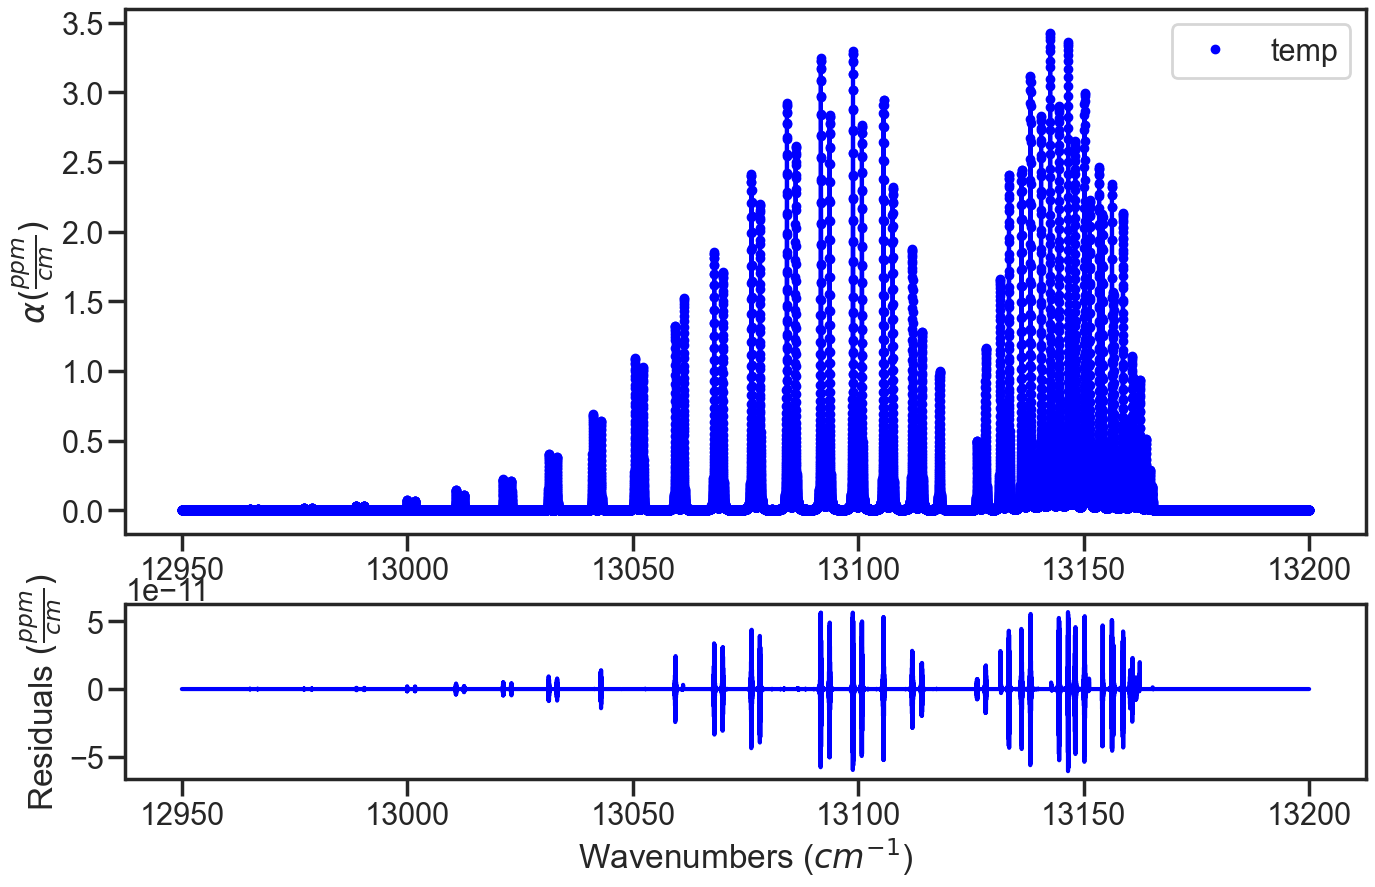

In [4]:
fit_data = MATS.Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', minimum_parameter_fit_intensity = Fit_Intensity)
params = fit_data.generate_params()
result = fit_data.fit_data(params, wing_cutoff = 25, wing_method = 'wing_cutoff')
fit_data.residual_analysis(result, indv_resid_plot=False)
fit_data.update_params(result)
SPECTRA.generate_summary_file(save_file = True)
SPECTRA.plot_model_residuals()

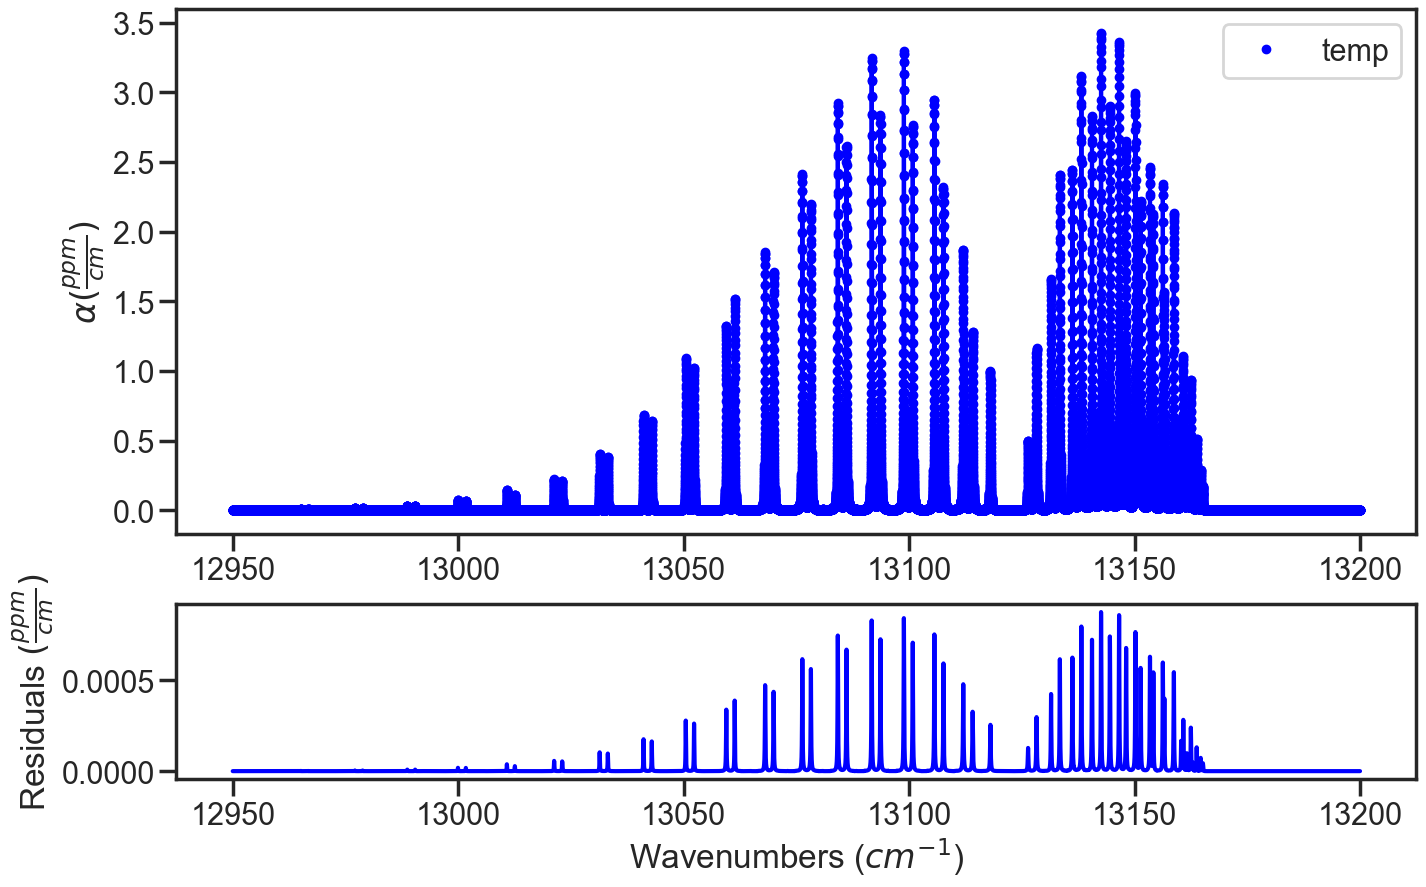

In [5]:
spec_1.compressability_file = None
fit_data = MATS.Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', minimum_parameter_fit_intensity = Fit_Intensity)
params = fit_data.generate_params()
result = fit_data.fit_data(params, wing_cutoff = 25, wing_method = 'wing_cutoff')
fit_data.residual_analysis(result, indv_resid_plot=False)
fit_data.update_params(result)
SPECTRA.generate_summary_file(save_file = True)
SPECTRA.plot_model_residuals()

In [6]:
from scipy.interpolate import RegularGridInterpolator
comp_factor = pd.read_csv('0.25%O2inN2_297K.csv')
pressures = np.asarray(comp_factor['Pressure (MPa)'].values*1e6/101325)
pressures = pressures.astype(float)
temperatures = list(comp_factor)
temperatures.remove('Pressure (MPa)')
temperatures = np.asarray(temperatures)
temperatures = temperatures.astype(float)
comp_factor.drop('Pressure (MPa)', inplace=True, axis=1) 
comp_factor_array = comp_factor.to_numpy()
interp_comp_factor = RegularGridInterpolator(points = [pressures, temperatures], values = comp_factor_array)

p =975/760
T = 298.15
compressability_factor = interp_comp_factor([p, T])[0]
compressability_factor                        

0.9997450051551453